<a href="https://colab.research.google.com/github/abjasree/higgs_boson/blob/main/recall_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Higgs Boson Challenge
This project is done as part of the Univ.ai AI-1 course. The Higgs boson machine learning challenge (HiggsML or Challenge in short) has been set up to promote collaboration between high energy physicists and data scientists. The ATLAS experiment at CERN provided simulated data used by physicists to optimize the analysis of the Higgs boson. The Challenge is organized by a small group of ATLAS physicists and data scientists. It is hosted by Kaggle at https://www.kaggle.com/c/higgs-boson. \



The goal of the Challenge is to improve the procedure that produces the selection region. We
provide a training set with signal/background labels and with weights, a test set (without labels and weights), and a formal objective representing an approximation of the median significance (AMS) of the counting test. The objective is a function of the weights of selected events. We expect that significant improvements are possible by re-visiting some of the ad hoc choices in the standard procedure, or by incorporating the objective function or a surrogate into the classifier design.


**Data** \
Here, we are trying to take data directly from the kaggle using the kaggle.json file which can be obtained after agree to abide with the rules of the competition. 

In [ ]:
! pip install kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=4c1a880ac21fe7a6d74a8aacf7db28ed7465f87bac8d5f0e820265ec0a75a473
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c higgs-boson

 76% 41.0M/54.3M [00:00<00:00, 89.0MB/s]
100% 54.3M/54.3M [00:00<00:00, 91.3MB/s]


In [ ]:
! unzip higgs-boson.zip
! unzip training.zip
! unzip test.zip

Archive:  higgs-boson.zip
  inflating: HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: random_submission.zip   
  inflating: test.zip                
  inflating: training.zip            
Archive:  training.zip
  inflating: training.csv            
Archive:  test.zip
  inflating: test.csv                


**Peek to the data**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")
test.head()


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,56.018,1.536,-1.404,-999.000,22.088,-0.540,-0.609,33.930,-0.504,-1.511,48.509,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
1,350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,132.865,1.777,-1.204,-999.000,30.716,-1.784,3.054,54.574,-0.169,1.795,21.093,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,97.600,1.096,-1.408,-999.000,46.564,-0.298,3.079,51.036,-0.548,0.336,19.461,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,94.112,0.819,-1.382,-999.000,51.741,0.388,-1.408,42.371,-0.295,2.148,25.131,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,721.552,1.713,-0.913,0.004,45.087,-1.548,1.877,77.252,-1.913,2.838,22.200,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


**Importing necessary libraries**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder,normalize,MinMaxScaler,StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import seaborn as sns

In [ ]:
import collections
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, normalize
import math

In [ ]:
x_vals = train["Label"].value_counts().index
y_vals = train["Label"].value_counts().values
print(x_vals)
print(y_vals)

Index(['b', 's'], dtype='object')
[164333  85667]


Text(0.5, 1.0, 'Number of background and signals in the training data')

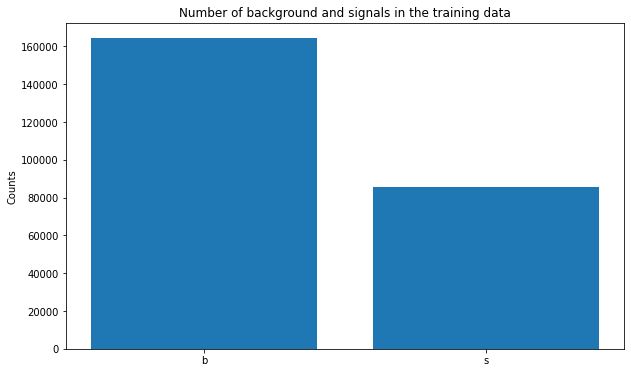

In [ ]:
plt.figure(figsize = (10, 6))
plt.bar(x_vals, y_vals)
plt.ylabel("Counts")
plt.title("Number of background and signals in the training data")

**Inference:** 
- From the plot above we can observe that there is a class imbalance for this dataset i.e., there is more data on the background class compared to the signal class 
- So, we will be using techniques to balance data and see if it performs better

# Data Preprocessing and Visualization
**Description of the features**
- **Event Id**: An unique integer identifier of the event. Not to be used as a feature. 
- **DER mass MMC**: The estimated mass $m_H$ of the Higgs boson candidate, obtained through a probabilistic phase space integration (may be undefined if the topology of the event is too far from the expected topology) 
- **DER mass transverse met lep**: The transverse mass between the missing transverse energy and the lepton. 
- **DER mass vis**: The invariant mass of the hadronic tau and the lepton.
- **DER pt h**: The modulus of the vector sum of the transverse momentum of the hadronic tau,
the lepton, and the missing transverse energy vector.
- **DER deltaeta jet jet** The absolute value of the pseudorapidity separation between the
two jets (undefined if PRI jet num ≤ 1). 
- **DER mass jet jet**: The invariant mass of the two jets (undefined if PRI jet num ≤ 1).
- **DER prodeta jet jet** The product of the pseudorapidities of the two jets (undefined if PRI jet num ≤
1).
- **DER deltar tau lep**: The R separation between the hadronic tau and the lepton.
- **DER pt tot**: The modulus of the vector sum of the missing transverse momenta and the
transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI jet num ≥ 1)
and the subleading jet (if PRI jet num = 2) (but not of any additional jets). 
- **DER sum pt**: The sum of the moduli of the transverse momenta of the hadronic tau, the
lepton, the leading jet (if PRI jet num ≥ 1) and the subleading jet (if PRI jet num = 2)
and the other jets (if PRI jet num = 3). 
- **DER pt ratio lep tau**: The ratio of the transverse momenta of the lepton and the hadronic
tau 
- **DER met phi centrality** The centrality of the azimuthal angle of the missing transverse energy vector w.r.t. the hadronic tau and the lepton \



### Data preprocessing : Median Imputation
- What we have done for the data is if the values are undefined i.e., -999 here we have replaced it with the median of the data columns whose values is not - 999

In [ ]:
train.loc[train.DER_mass_MMC<0,'DER_mass_MMC']=np.median(train.DER_mass_MMC[train.DER_mass_MMC>=0])

train.loc[train.PRI_jet_num<=1,'DER_deltaeta_jet_jet']=np.median(train.DER_deltaeta_jet_jet[train.PRI_jet_num>1])

train.loc[train.PRI_jet_num<=1,'DER_mass_jet_jet']=np.median(train.DER_mass_jet_jet[train.PRI_jet_num>1])

train.loc[train.PRI_jet_num<=1,'DER_prodeta_jet_jet']=np.median(train.DER_prodeta_jet_jet[train.PRI_jet_num>1])

train.loc[train.PRI_jet_num<1,'DER_pt_tot']=np.median(train.DER_pt_tot[train.PRI_jet_num>=1])

train.loc[train.PRI_jet_num<1,'DER_sum_pt']=np.median(train.DER_sum_pt[train.PRI_jet_num>=1])

train.loc[train.PRI_jet_num<=1,'DER_lep_eta_centrality']=np.median(train.DER_lep_eta_centrality[train.PRI_jet_num>1])

train.loc[train.PRI_jet_num==0,'PRI_jet_leading_pt']=np.median(train.PRI_jet_leading_pt[train.PRI_jet_num!=0])

train.loc[train.PRI_jet_num==0,'PRI_jet_leading_eta']=np.median(train.PRI_jet_leading_eta[train.PRI_jet_num!=0])

train.loc[train.PRI_jet_num==0,'PRI_jet_leading_phi']=np.median(train.PRI_jet_leading_phi[train.PRI_jet_num!=0])

train.loc[train.PRI_jet_num<=1,'PRI_jet_subleading_pt']=np.median(train.PRI_jet_subleading_pt[train.PRI_jet_num>1])

train.loc[train.PRI_jet_num<=1,'PRI_jet_subleading_eta']=np.median(train.PRI_jet_subleading_eta[train.PRI_jet_num>1])

train.loc[train.PRI_jet_num<=1,'PRI_jet_subleading_phi']=np.median(train.PRI_jet_subleading_phi[train.PRI_jet_num>1])

**Plotting the distribution of features**

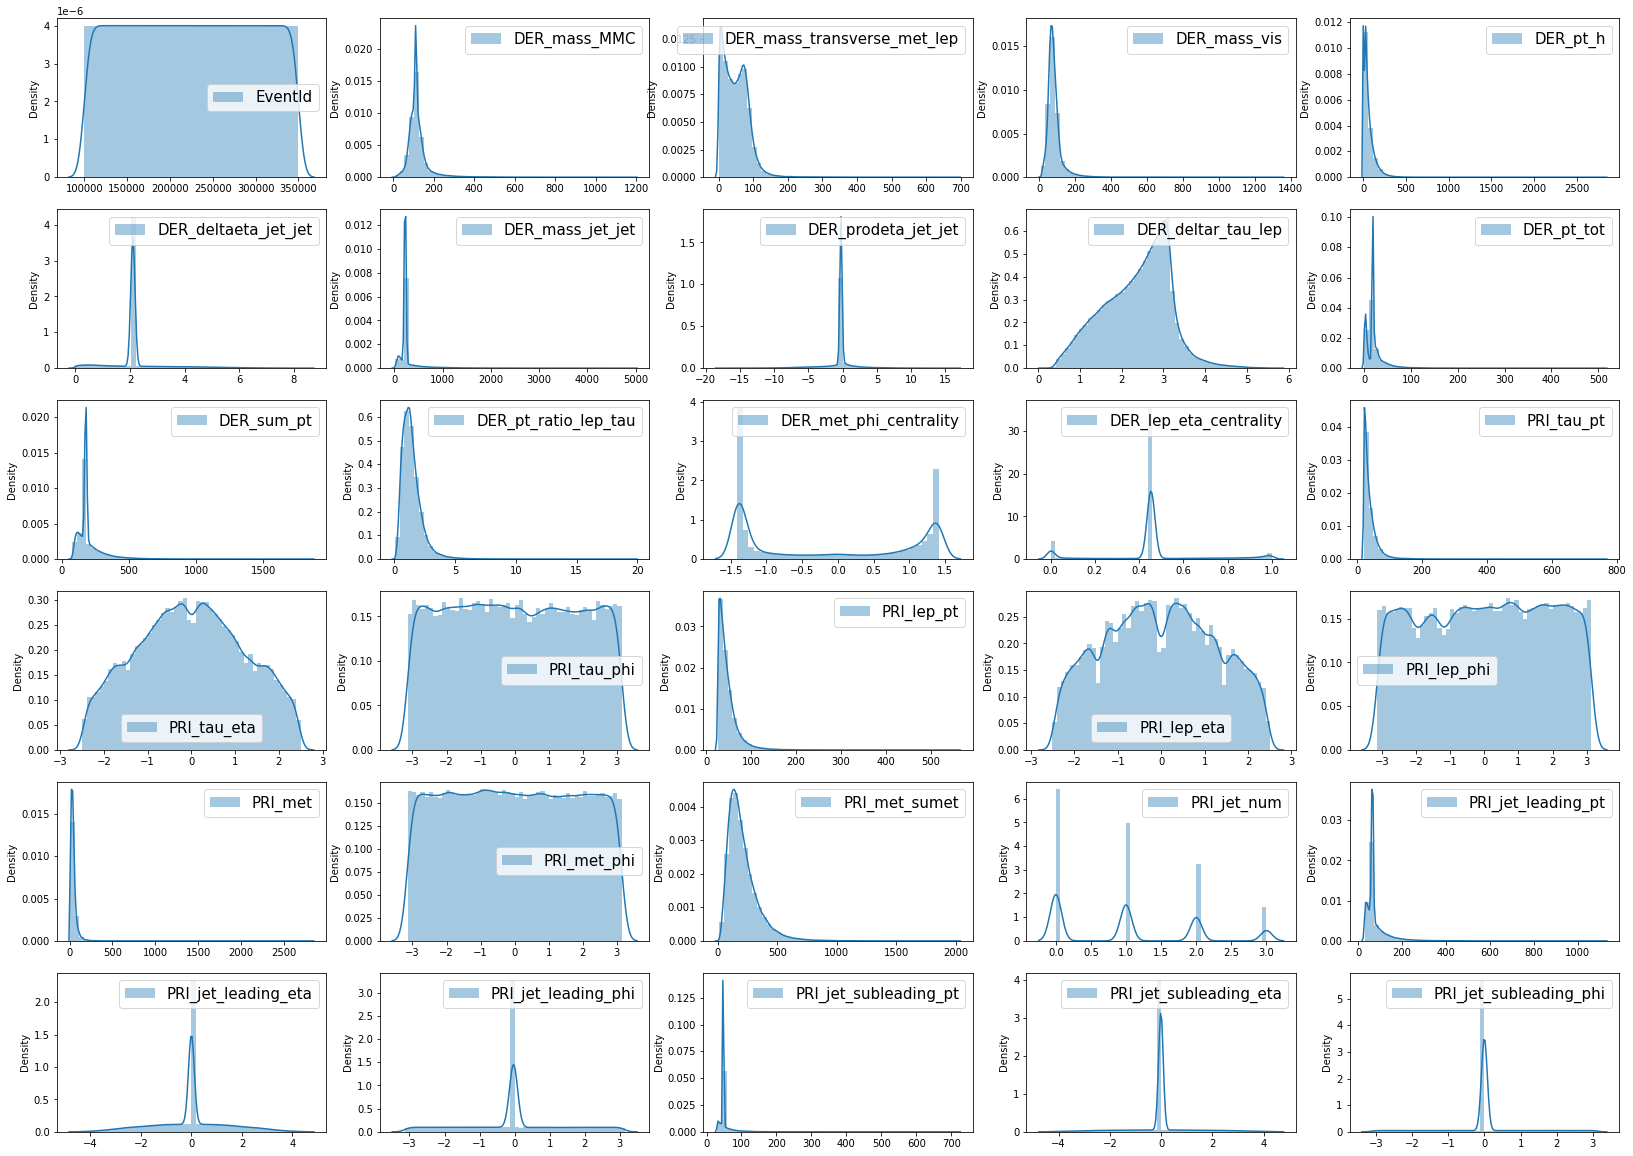

In [ ]:
plt.figure(figsize=(28,24))
for i in range(30):
    plt.subplot(7,5,i+1)
    sns.distplot(train[train.columns[i]].values, label=train.columns[i])
    plt.legend(fontsize=15)   
plt.show()

**Inference:** 
- Here, we can observe the distribution of different features given as the data
- These distribution let's us know that some are symmetric distribution and some are long tailed distribution and these gives us the general idea to transform the features if we get bad results.

**Correlation Matrix**

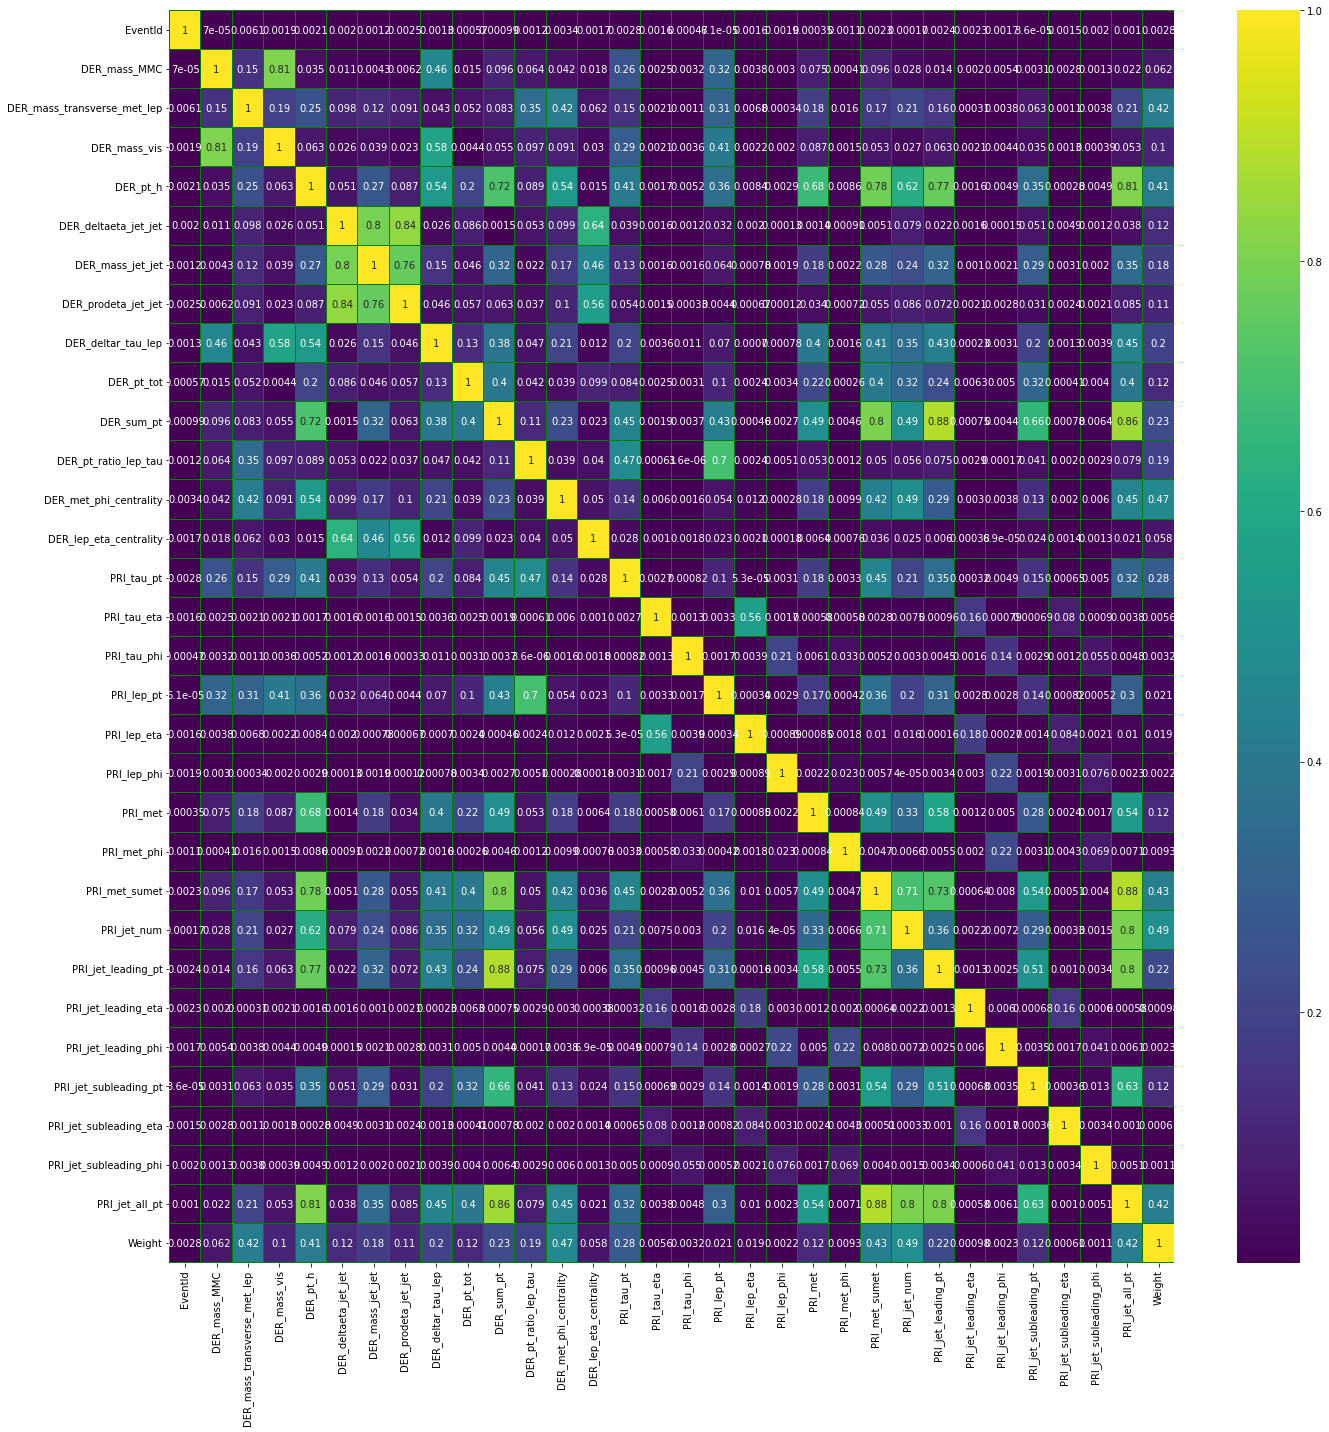

In [ ]:
plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams["figure.autolayout"] = True

sns.heatmap(np.abs(train.corr()), cmap='viridis', linecolor='green', linewidth=0.01, annot=True)
plt.show()

**Inference:**
- The correlation matrix has been plotted to see the correlated features 

**Plots to see how the log transformation can make the long tailed distribution symmetric**

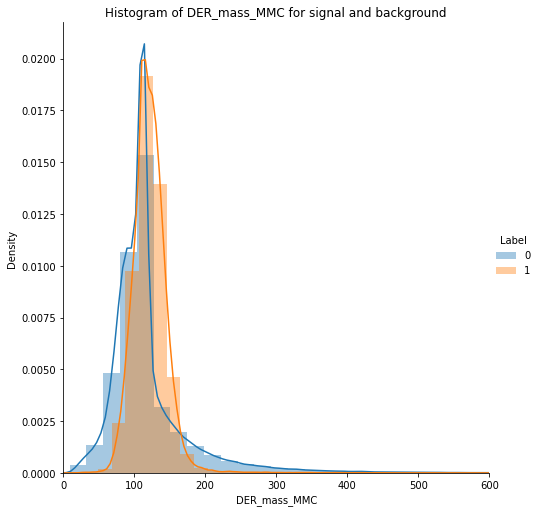

In [ ]:
sns.FacetGrid(train, hue="Label", size = 7)\
  .map(sns.distplot, "DER_mass_MMC")\
  .add_legend()
plt.xlim(0, 600)
plt.xlabel("DER_mass_MMC")
plt.title("Histogram of DER_mass_MMC for signal and background")
plt.show()


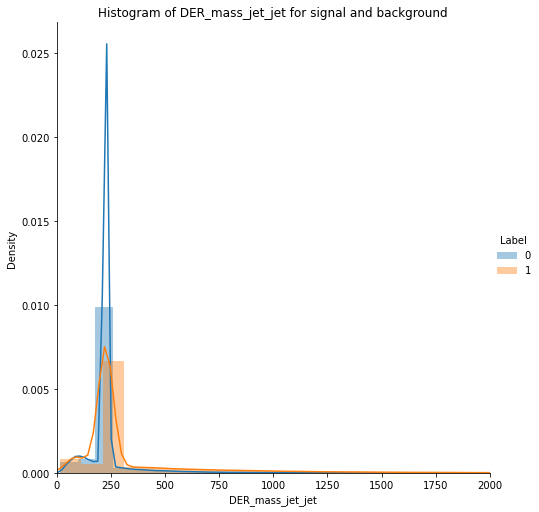

In [ ]:
sns.FacetGrid(train, hue="Label", size = 7)\
  .map(sns.distplot, "DER_mass_jet_jet")\
  .add_legend()
plt.xlim(0, 2000)
plt.xlabel("DER_mass_jet_jet")
plt.title("Histogram of DER_mass_jet_jet for signal and background")
plt.show()


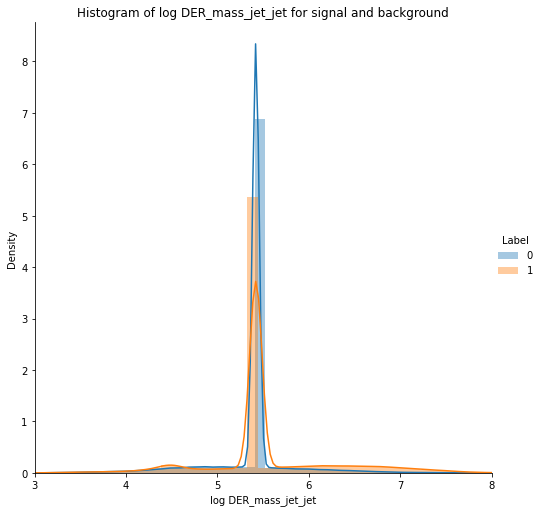

In [ ]:
df = train
df["log_DER_mass_jet_jet"] = np.log(train["DER_mass_jet_jet"])
sns.FacetGrid(df, hue="Label", size = 7)\
  .map(sns.distplot, "log_DER_mass_jet_jet")\
  .add_legend()
plt.xlim(3, 8)
plt.xlabel("log DER_mass_jet_jet")
plt.title("Histogram of log DER_mass_jet_jet for signal and background")
plt.show()

**Inference:**
- The top 2 plots show the long tailed distribution of 2 features and the last plot shows the plot of their log
- From the above plots we can observe that doing the log transform we can make a symmetric distribution
- So if the results are not good we can try using the log transform of the features instead of using the feature itself

###Encoding the labels

In [ ]:
enc = LabelEncoder()
train["Label"] = enc.fit_transform(train["Label"])
train.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.200,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,1
1,100001,160.937,68.768,103.235,48.146,2.107,225.885,-0.244,3.473,2.078,125.157,0.879,1.414,0.454,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,47.902,-0.01,-0.002,46.226,2.233584,0
2,100002,112.406,162.172,125.953,35.635,2.107,225.885,-0.244,3.148,9.336,197.814,3.776,1.414,0.454,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,47.902,-0.01,-0.002,44.251,2.347389,0
3,100003,143.905,81.417,80.943,0.414,2.107,225.885,-0.244,3.310,18.231,178.643,2.354,-1.285,0.454,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,65.561,0.000,-0.033,47.902,-0.01,-0.002,-0.000,5.446378,0
4,100004,175.864,16.915,134.805,16.405,2.107,225.885,-0.244,3.891,18.231,178.643,1.056,-1.385,0.454,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,65.561,0.000,-0.033,47.902,-0.01,-0.002,0.000,6.245333,0


- The labels were signal and background, we make them to 0 and 1 so that the computer can understand

**Making the features and labels from the dataset:**
- We take all the features except the label as the features to train the model (x)
- We take the label as output which the model should learn to predict (y)

In [ ]:
x=train.drop(["Label"],axis=1)
# Since 'EventId' is not a feature
x.set_index('EventId',inplace=True)
#x_test = test.set_index('EventId',inplace=True)
y=train['Label']
test.head()
x.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
EventId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.200,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653
100001,160.937,68.768,103.235,48.146,2.107,225.885,-0.244,3.473,2.078,125.157,0.879,1.414,0.454,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,47.902,-0.01,-0.002,46.226,2.233584
100002,112.406,162.172,125.953,35.635,2.107,225.885,-0.244,3.148,9.336,197.814,3.776,1.414,0.454,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,47.902,-0.01,-0.002,44.251,2.347389
100003,143.905,81.417,80.943,0.414,2.107,225.885,-0.244,3.310,18.231,178.643,2.354,-1.285,0.454,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,65.561,0.000,-0.033,47.902,-0.01,-0.002,-0.000,5.446378
100004,175.864,16.915,134.805,16.405,2.107,225.885,-0.244,3.891,18.231,178.643,1.056,-1.385,0.454,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,65.561,0.000,-0.033,47.902,-0.01,-0.002,0.000,6.245333


### Scaling:
- We scale the values using standard scaler so that the values of each feature lies between 0 to 1
- It is important to scale the data because it helps the iterative algorithm to reach the minima faster than the unscaled data 

In [ ]:
scalable_cols = ['DER_mass_MMC','DER_mass_transverse_met_lep','DER_mass_vis','DER_pt_h','DER_mass_jet_jet','DER_pt_tot',
                'DER_sum_pt','PRI_tau_pt','PRI_lep_pt','PRI_met','PRI_met_sumet','PRI_jet_leading_pt','PRI_jet_subleading_pt'
                ,'PRI_jet_all_pt']
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(x[scalable_cols]), columns = scalable_cols)
#test_scaled = pd.DataFrame(scaler.transform(test[scalable_cols]), columns = scalable_cols)

for i in x.columns:
    if i not in scalable_cols:
        train_scaled[i] = x[i].values
        #test_scaled[i] = test[i].values

### Splitting the data to train and test
- Here, we are splitting the data to train and test 
- It is important to test our results with the unseen data to see how our model performs

In [ ]:
x_train_w, x_val_w, y_train, y_val = train_test_split(train_scaled, y, train_size = 0.8, random_state = 44)
x_train_w.shape

(200000, 31)

- Here, we are saving the weights of the data points inorder to compute the AMS which is absolute median importance which is a metric for the evaluation in the kaggle competition

In [ ]:
x_train = x_train_w.drop(["Weight"],axis = 1)
weights = x_val_w["Weight"].tolist()
x_val = x_val_w.drop(["Weight"], axis =1)
print(len(weights))
print(len(y_val))
print(x_train.shape)
print(x_val.shape)
print(len(y_val.values.tolist()))

50000
50000
(200000, 30)
(50000, 30)
50000


# Defining AMS

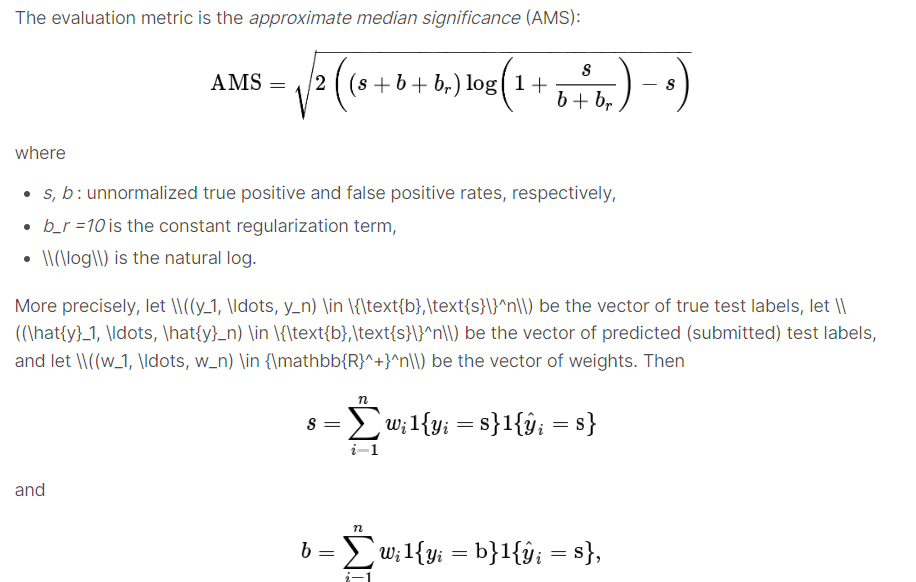

In [ ]:
# to get unnormalized true positive and false positive rates
import math
def evaluation(y, pred, weight):
    s = 0
    b = 0

    for i in range(len(weight)):
        if pred[i]== 1 and y[i]== 1:
            s += weight[i]
        if pred[i]== 1 and y[i]== 0:
            b += weight[i]

    
    # s, b, br=10

    br = 10

    AMS = math.sqrt(2*(((s+b+br)*math.log(1+s/(b+br)) - s)))
    return AMS

# Upsampling to make Balance dataset using SMOTE
- As we saw from the above plot our dataset is imbalanced
- Imbalanced means the signal is much less compared to background 
- In upsampling we make the signal data points as equal number as that of background data points using the SMOTE in sklearn

In [ ]:
# Perform upsampling using SMOTE

# Define a SMOTE with random_state=2
sm = SMOTE(random_state = 2)

# Use the SMOTE object to upsample the train data
# You may have to use ravel() 
x_train_up, y_train_up = sm.fit_resample(x_train, y_train)

# Downsampling to make Balance data set using RandomUnderSampler
- As mentioned above the data is imbalanced
- Here, we downsample the data i.e., we make the data points of background equal to that of signal using randomundersampler in sklearn

In [ ]:
# Define an RandomUnderSampler instance with random state as 2
rs = RandomUnderSampler(random_state = 2)


x_train_down, y_train_down = rs.fit_resample(x_train, y_train)

# Base Models
- Here, we are trying the base models i.e., the logistic regression and the decision tree to classify the data points 

## Logistic Regression


### Imbalanced data
- We are using the logistic regression to the imbalance data

In [ ]:
from sklearn.linear_model import LogisticRegression
def best_classifier(clf, params, X,y, n_folds = 5, scoring = "recall"):
    gs = GridSearchCV(clf, param_grid = params, cv=n_folds, scoring = "recall")
    gs.fit(X,y)
    print("BEST", gs.best_params_, round(gs.best_score_,2))
    best = gs.best_estimator_
    return best

In [ ]:
#Tuning for Logistic regression
logreg = LogisticRegression(solver= 'lbfgs', max_iter=100, random_state = 44)
c_values = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Finding the best value of C
best = best_classifier(logreg, c_values,x_train, y_train, n_folds = 5, scoring = "recall")

BEST {'C': 10} 0.54


- Here, we have used the gridsearchcv to find the best value of c in the logistic regression from the list of the values of c given that will give the best recall for the model

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(max_iter=100,solver = 'lbfgs',C=10, random_state = 44)

logreg.fit(x_train, y_train)

y_pred_logreg = logreg.predict(x_val)
cm_test_logreg = confusion_matrix(y_val, y_pred_logreg)
acc_logreg = accuracy_score(y_val, y_pred_logreg)


f_score_logreg = f1_score(y_val, y_pred_logreg)

recall_logreg = (cm_test_logreg[1][1])/cm_test_logreg.sum(axis=1)[1]

print(f'Accuracy for test set for Logistic Regression = {acc_logreg:.4f}')
print(f'Accuracy for TPR/recall for Logistic Regression for test = {recall_logreg:.4f}')
print(f'F1 score : {f_score_logreg:.4f} ')
#print(f'Accuracy for test set for Logistic Regression = {(cm_test[0][0] + cm_test[1][1])/len(y_test):.2f}')

Accuracy for test set for Logistic Regression = 0.7498
Accuracy for TPR/recall for Logistic Regression for test = 0.5333
F1 score : 0.5946 


In [ ]:
y_val_i = y_val.values.tolist()
ams_logreg = evaluation(y_val_i, y_pred_logreg, weights)
print(f"The AMS value from Logistic Regression: {ams_logreg}")

The AMS value from Logistic Regression: 0.8745259841590599


**Inference:**
- Here, we have calculated the accuracy and recall and F1 score for the logistic regression model 
- We can observe that the recall and AMS value is quite less for the logistic regression


**Permutation Importance**
- We used the permuation importance in the sklearn to find the important features in the logistic regression model

Text(0.5, 1.0, 'Bar plot of Importances for Logistic Regression Model')

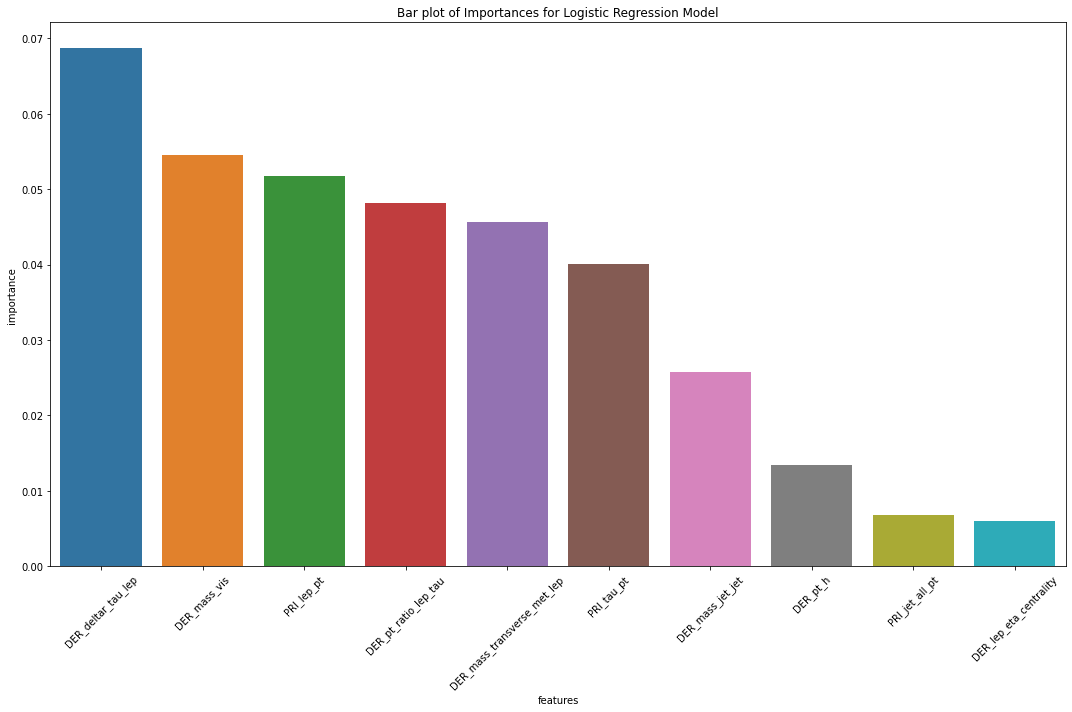

In [ ]:
def permutation_imp(model, imp_features, imp, impstd = 0):
    return pd.DataFrame({'features':imp_features, 'importance':imp, 'importance_std': impstd}
                       ).sort_values('importance', ascending=False)
features_imp =permutation_importance(logreg, x_val, y_val)
imp_feature_df = permutation_imp(logreg,list(x_train.columns),features_imp['importances_mean'],features_imp['importances_std']).iloc[:10]
fig,ax=plt.subplots(figsize=(15,10))
sns.barplot(data=imp_feature_df,x='features',y='importance',label='Logistic_Regression_importances',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Logistic Regression Model")

**Inference:** 
- This plot shows the 10 important features for the logistic regression model using the permutation importance

### With Upsampled data
- Here, we are using the upsampled data we obtained using SMOTE for the logistic regression model 
- We are using the gridsearchcv to obtain the best c which gives us the best recall for the model

In [ ]:
logreg_up = LogisticRegression(solver= 'lbfgs', max_iter=100, random_state = 44)
c_values = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}


#Finding the best value of C
best = best_classifier(logreg_up, c_values,x_train_up, y_train_up, n_folds = 5, scoring = "recall")

BEST {'C': 0.1} 0.77


In [ ]:
logreg_up = LogisticRegression(max_iter=100,solver = 'lbfgs',C=0.1, random_state = 44)

logreg_up.fit(x_train_up, y_train_up)

y_pred_logreg_up = logreg_up.predict(x_val)
cm_test_logreg_up = confusion_matrix(y_val, y_pred_logreg_up)


f_score_logreg_up = f1_score(y_val, y_pred_logreg_up)

recall_logreg_up = (cm_test_logreg_up[1][1])/cm_test_logreg_up.sum(axis=1)[1]

print(f'Accuracy for test set for Logistic Regression for upsampled data= {(cm_test_logreg_up[0][0] + cm_test_logreg_up[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Logistic Regression for upsampled data = {recall_logreg_up:.2f}')
print(f'F1 score : {f_score_logreg_up} ')



Accuracy for test set for Logistic Regression for upsampled data= 0.7379
Accuracy for TPR/recall for Logistic Regression for upsampled data = 0.76
F1 score : 0.6668361639377606 


In [ ]:
y_val_i = y_val.values.tolist()
ams_logreg_up = evaluation(y_val_i, y_pred_logreg_up, weights)
print(f"The AMS value from Logistic Regression for Up Sampled data: {ams_logreg_up}")

The AMS value from Logistic Regression for Up Sampled data: 0.8851876897320499


**Inference:** 
- We can observe that the recall, f1 score and AMS improved for the model which used upsampled data instead of just using the imbalanced data

Text(0.5, 1.0, 'Bar plot of Importances for Logistic Regression  Model for Upsampled data')

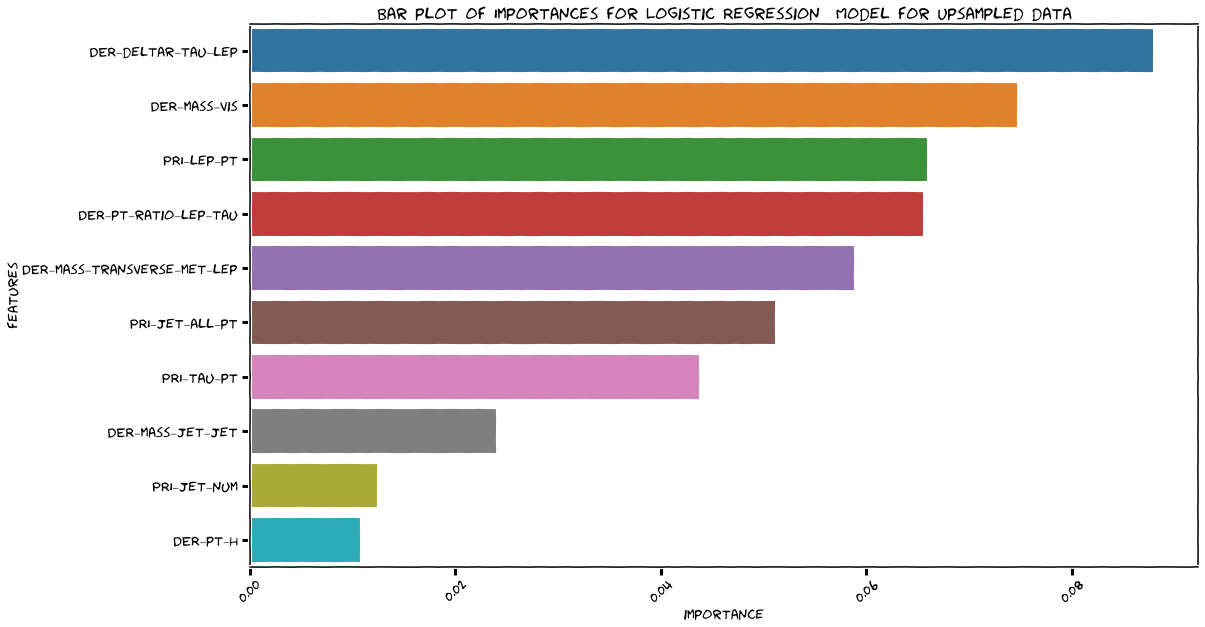

In [ ]:
def permutation_imp(model, imp_features, imp, impstd = 0):
    return pd.DataFrame({'features':imp_features, 'importance':imp, 'importance_std': impstd}
                       ).sort_values('importance', ascending=False)
features_imp =permutation_importance(logreg_up, x_val, y_val)
imp_feature_df = permutation_imp(logreg_up,list(x_train.columns),features_imp['importances_mean'],features_imp['importances_std']).iloc[:10]
fig,ax=plt.subplots(figsize=(17,10))
sns.barplot(data=imp_feature_df,y='features',x='importance',label='Logistic_Regression_importances',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Logistic Regression  Model for Upsampled data")

**Inference:** 
- This plot shows the 10 important features for the logistic regression model using the permutation importance for the upsampled data

### With undersampled data
- Here, we are using the undersampled data we obtained using randomundersampler for the logistic regression model 
- We are using the gridsearchcv to obtain the best c which gives us the best recall for the model

In [ ]:
logreg_down = LogisticRegression(solver= 'lbfgs', max_iter=100, random_state = 44)
c_values = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Finding the best value of C
best = best_classifier(logreg_down, c_values,x_train_down, y_train_down, n_folds = 5, scoring = "recall")

BEST {'C': 10} 0.77


In [ ]:
logreg_down = LogisticRegression(max_iter=10000,solver = 'lbfgs',C=10, random_state = 44)

logreg_down.fit(x_train_down, y_train_down)

y_pred_logreg_down = logreg_down.predict(x_val)
cm_test_logreg_down = confusion_matrix(y_val, y_pred_logreg_down)
f_score_logreg_down = f1_score(y_val, y_pred_logreg_down)

recall_logreg_down = (cm_test_logreg_down[1][1])/cm_test_logreg_down.sum(axis=1)[1]

print(f'Accuracy for test set for Logistic Regression for undersampled data= {(cm_test_logreg_down[0][0] + cm_test_logreg_down[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Logistic Regression for undersampled data = {recall_logreg_down:.4f}')
print(f'F1 score : {f_score_logreg_down:.4f} ')

Accuracy for test set for Logistic Regression for undersampled data= 0.7372
Accuracy for TPR/recall for Logistic Regression for undersampled data = 0.7702
F1 score : 0.6685 


In [ ]:
y_val_i = y_val.values.tolist()
ams_logreg_down = evaluation(y_val_i, y_pred_logreg_down, weights)
print(f"The AMS value for Logistic Regression for Under Sampled data: {ams_logreg_down}")

The AMS value for Logistic Regression for Under Sampled data: 0.8900526838688215


**Inference:** 
- We can observe that the recall, f1 score and AMS improved for the model which used undersampled data instead of just using the imbalanced data

Text(0.5, 1.0, 'Bar plot of Importances for Logistic Regression  Model for Under sampled data')

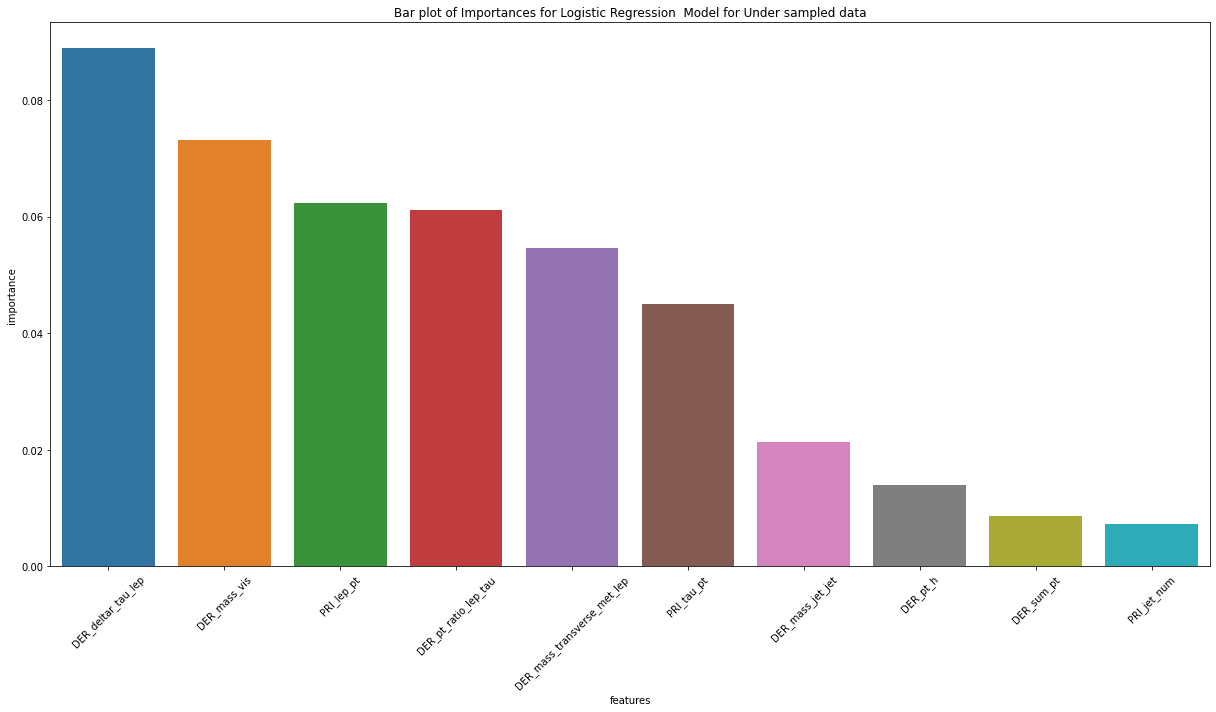

In [ ]:
def permutation_imp(model, imp_features, imp, impstd = 0):
    return pd.DataFrame({'features':imp_features, 'importance':imp, 'importance_std': impstd}
                       ).sort_values('importance', ascending=False)
features_imp =permutation_importance(logreg_down, x_val, y_val)
imp_feature_df = permutation_imp(logreg_down,list(x_train.columns),features_imp['importances_mean'],features_imp['importances_std']).iloc[:10]
fig,ax=plt.subplots(figsize=(17,10))
sns.barplot(data=imp_feature_df,x='features',y='importance',label='Logistic_Regression_importances',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Logistic Regression  Model for Under sampled data")

**Inference:** 
- This plot shows the 10 important features for the logistic regression model using the permutation importance for the undersampled data

## Decision Tree 


### Imbalanced data
- We are using the decision tree to the imbalance data
- Here, we have used the gridsearchcv to find the best value for the parameters of the decision that will give the best recall for the model

In [ ]:
dt = DecisionTreeClassifier(random_state = 44)
parameters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
param_grid = { 'criterion':['gini'],'max_depth': parameters, 'min_samples_leaf': [3, 4, 5, 6, 7]}
best = best_classifier(dt, param_grid, x_train, y_train, n_folds = 5, scoring = "recall")
print(best)

BEST {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3} 0.71
DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, random_state=44)


In [ ]:
dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, min_samples_leaf = 3,  random_state = 44)

dt.fit(x_train, y_train)

y_pred_dt = dt.predict(x_val)
cm_test_dt = confusion_matrix(y_val, y_pred_dt)

f_score_dt = f1_score(y_val, y_pred_dt)

recall_dt = (cm_test_dt[1][1])/cm_test_dt.sum(axis=1)[1]

print(f'Accuracy for test set for Decision Tree Classifier= {(cm_test_dt[0][0] + cm_test_dt[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Decision Tree Classifier = {recall_dt:.4f}')
print(f'F1 score : {f_score_dt:.4f} ')

Accuracy for test set for Decision Tree Classifier= 0.8225
Accuracy for TPR/recall for Decision Tree Classifier = 0.7045
F1 score : 0.7320 


In [ ]:
y_val_i = y_val.values.tolist()
ams_dt = evaluation(y_val_i, y_pred_dt, weights)
print(f"The AMS value for Decision Tree Classifier: {ams_dt}")

The AMS value for Decision Tree Classifier: 1.1556237952034387


**Inference:**
- Here, we have calculated the accuracy, recall, F1 score and AMS score for the decison tree model
- We can observe that the accuracy, recall, F1 score and AMS score is quite high for the decision tree model compared to the logistic regression model

Text(0.5, 1.0, 'Bar plot of Importances for Decision Tree Model')

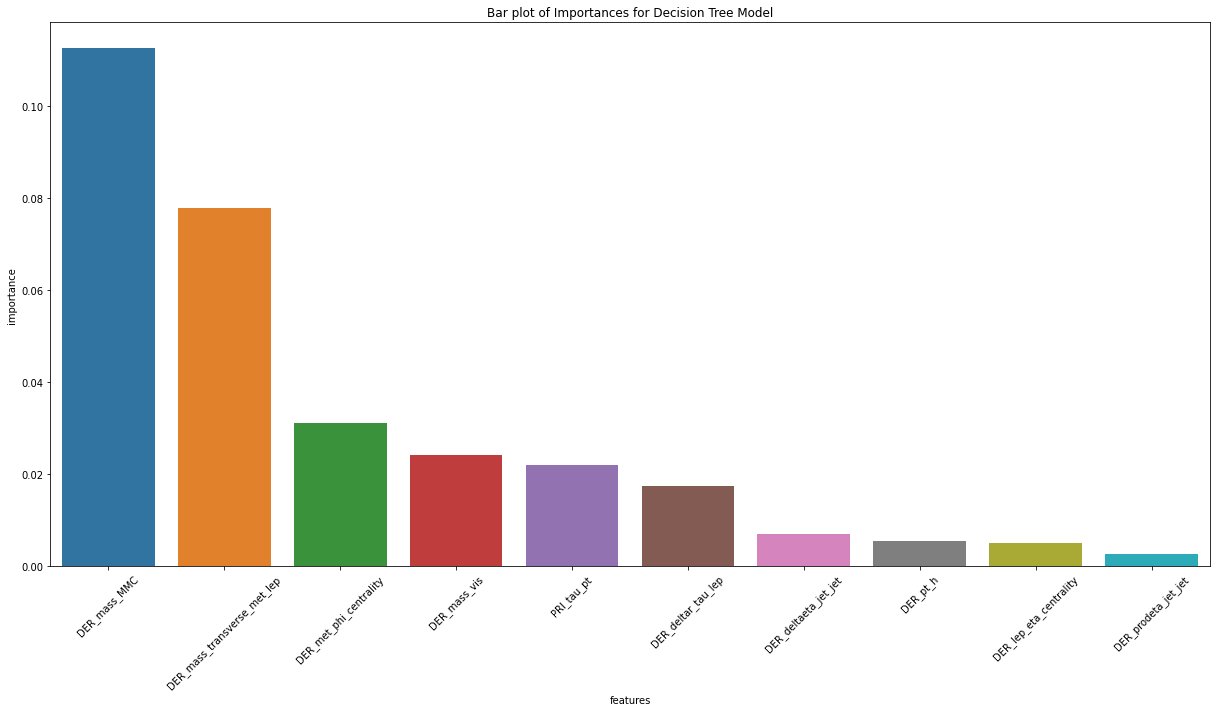

In [ ]:
def permutation_imp(model, imp_features, imp, impstd = 0):
    return pd.DataFrame({'features':imp_features, 'importance':imp, 'importance_std': impstd}
                       ).sort_values('importance', ascending=False)
features_imp =permutation_importance(dt, x_val, y_val)
imp_feature_df = permutation_imp(dt,list(x_train.columns),features_imp['importances_mean'],features_imp['importances_std']).iloc[:10]
fig,ax=plt.subplots(figsize=(17,10))
sns.barplot(data=imp_feature_df,x='features',y='importance',label='Decision tree importance',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Decision Tree Model")

**Inference:** 
- This plot shows the 10 important features for the decision tree model using the permutation importance

### For upsampled data
- Here, we are using the upsampled data we obtained using SMOTE for the decision tree model 
- We are using the gridsearchcv to obtain the best parameters which gives us the best recall for the model

In [ ]:
dt_up = DecisionTreeClassifier(random_state = 44)
parameters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
param_grid = { 'criterion':['gini'],'max_depth': parameters, 'min_samples_leaf': [3, 4, 5, 6, 7]}
best = best_classifier(dt_up, param_grid,x_train_up, y_train_up, n_folds = 5, scoring = "recall")
print(best)

BEST {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 7} 0.84
DecisionTreeClassifier(max_depth=9, min_samples_leaf=7, random_state=44)


In [ ]:
dt_up = DecisionTreeClassifier(criterion = 'gini', max_depth = 9 , min_samples_leaf = 7,  random_state = 44)

dt_up.fit(x_train_up, y_train_up)

y_pred_dt_up = dt_up.predict(x_val)
cm_test_dt_up = confusion_matrix(y_val, y_pred_dt_up)

f_score_dt_up = f1_score(y_val, y_pred_dt_up)

recall_dt_up = (cm_test_dt_up[1][1])/cm_test_dt_up.sum(axis=1)[1]

print(f'Accuracy for test set for Decision Tree Classifier for up sampled data= {(cm_test_dt_up[0][0] + cm_test_dt_up[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Decision Tree Classifier for up sampled data = {recall_dt_up:.4f}')
print(f'F1 score for upsampled data : {f_score_dt_up:.4f} ')

Accuracy for test set for Decision Tree Classifier for up sampled data= 0.8078
Accuracy for TPR/recall for Decision Tree Classifier for up sampled data = 0.8025
F1 score for upsampled data : 0.7418 


In [ ]:
y_val_i = y_val.values.tolist()
ams_dt_up = evaluation(y_val_i, y_pred_dt_up, weights)
print(f"The AMS value for Decision Tree for Upsampled data: {ams_dt_up}")

The AMS value for Decision Tree for Upsampled data: 1.025182486235552


**Inference:** 
- We can observe that the recall, f1 score and accuracy improved for the model which used upsampled data instead of just using the imbalanced data but the AMS score seems to be decreased slightly compared to the imbalanced data 

Text(0.5, 1.0, 'Bar plot of Importances for Decision Tree Model for upsampled data')

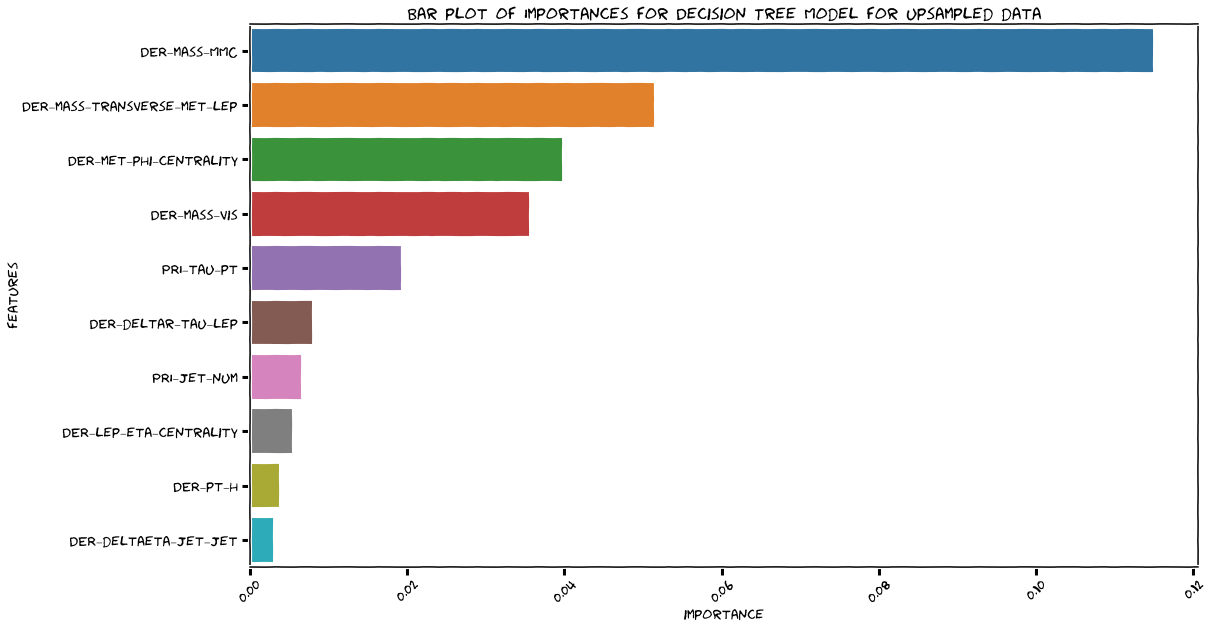

In [ ]:
def permutation_imp(model, imp_features, imp, impstd = 0):
    return pd.DataFrame({'features':imp_features, 'importance':imp, 'importance_std': impstd}
                       ).sort_values('importance', ascending=False)
features_imp =permutation_importance(dt_up, x_val, y_val)
imp_feature_df = permutation_imp(dt_up,list(x_train.columns),features_imp['importances_mean'],features_imp['importances_std']).iloc[:10]
fig,ax=plt.subplots(figsize=(17,10))
sns.barplot(data=imp_feature_df,y='features',x='importance',label='Decision tree importance',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Decision Tree Model for upsampled data")

**Inference:** 
- This plot shows the 10 important features for the decision tree model using the permutation importance for the upsampled data

###  For undersampled data
- Here, we are using the undersampled data we obtained using randomundersampler for the decision tree model 
- We are using the gridsearchcv to obtain the best parameters which gives us the best recall for the model

In [ ]:
dt_down = DecisionTreeClassifier(random_state = 44)
parameters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
param_grid = { 'criterion':['gini'],'max_depth': parameters, 'min_samples_leaf': [3, 4, 5, 6, 7]}
best = best_classifier(dt_down, param_grid,x_train_down, y_train_down, n_folds = 5, scoring = "recall")
print(best)

BEST {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5} 0.81
DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=44)


In [ ]:
dt_down = DecisionTreeClassifier(criterion = 'gini', max_depth = 10 , min_samples_leaf = 5,  random_state = 44)

dt_down.fit(x_train_down, y_train_down)

y_pred_dt_down = dt_down.predict(x_val)
cm_test_dt_down = confusion_matrix(y_val, y_pred_dt_down)

f_score_dt_down = f1_score(y_val, y_pred_dt_down)

recall_dt_down = (cm_test_dt_down[1][1])/cm_test_dt_down.sum(axis=1)[1]

print(f'Accuracy for test set for Decision Tree Classifier for down sampled data= {(cm_test_dt_down[0][0] + cm_test_dt_down[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Decision Tree Classifier for down sampled data = {recall_dt_down:.4f}')
print(f'F1 score for down sampled data : {f_score_dt_down:.4f} ')

Accuracy for test set for Decision Tree Classifier for down sampled data= 0.8046
Accuracy for TPR/recall for Decision Tree Classifier for down sampled data = 0.8154
F1 score for down sampled data : 0.7417 


In [ ]:
y_val_i = y_val.values.tolist()
ams_dt_down = evaluation(y_val_i, y_pred_dt_down, weights)
print(f"The AMS value from Decision Tree for Under Sampled data: {ams_dt_down}")

The AMS value from Decision Tree for Under Sampled data: 1.0071879107595598


**Inference:** 
- We can observe that the recall, f1 score and accuracy improved for the model which used downsampled data instead of just using the imbalanced data but the AMS score seems to be decreased slightly compared to the imbalanced data 

Text(0.5, 1.0, 'Bar plot of Importances for Decision Tree Model for down sampled data')

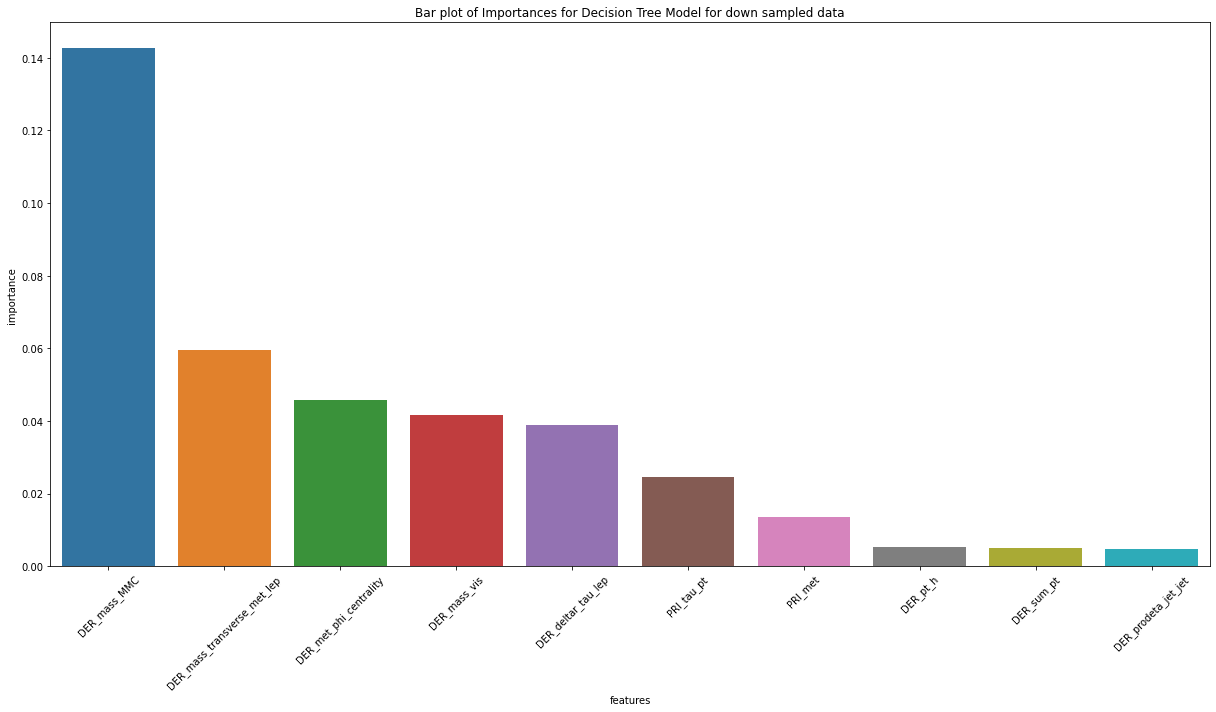

In [ ]:
def permutation_imp(model, imp_features, imp, impstd = 0):
    return pd.DataFrame({'features':imp_features, 'importance':imp, 'importance_std': impstd}
                       ).sort_values('importance', ascending=False)
features_imp =permutation_importance(dt_down, x_val, y_val)
imp_feature_df = permutation_imp(dt_down,list(x_train.columns),features_imp['importances_mean'],features_imp['importances_std']).iloc[:10]
fig,ax=plt.subplots(figsize=(17,10))
sns.barplot(data=imp_feature_df,x='features',y='importance',label='Decision tree importance',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Decision Tree Model for down sampled data")

**Inference:** 
- This plot shows the 10 important features for the decision tree model using the permutation importance for the downsampled data

# The Ensemble Models
- We are using the different decision tree based ensemble models since the decision tree model was giving better values for accuracy, recall, f1 score and AMS score for the decision tree models

## Random Forest 


### Imbalanced data
- We are using the random forest to the imbalance data
- Here, we have used the gridsearchcv to find the best value for the parameters of the random forest that will give the best recall for the model

In [ ]:

random_forest = RandomForestClassifier(n_estimators = 10,random_state = 44)

# Fit the model on the training set
# tried depth from 1,2, 3, 4, .....14 but got 14 
parameters = [ 14, 15, 16, 17]
param_grid = { 'criterion':['gini'],'max_depth': parameters, 'min_samples_leaf': [3, 4, 5, 6, 7]}
best = best_classifier(random_forest, param_grid,x_train, y_train, n_folds = 5, scoring = "recall")
print(best)

BEST {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 5} 0.7
RandomForestClassifier(max_depth=16, min_samples_leaf=5, n_estimators=10,
                       random_state=44)


In [ ]:
random_forest = RandomForestClassifier(criterion = 'gini', n_estimators = 100, max_depth = 16 , min_samples_leaf = 5, random_state = 44)

random_forest.fit(x_train, y_train)

y_pred_rf = random_forest.predict(x_val)
cm_test_rf = confusion_matrix(y_val, y_pred_rf)

f_score_rf = f1_score(y_val, y_pred_rf)

recall_rf = (cm_test_rf[1][1])/cm_test_rf.sum(axis=1)[1]

print(f'Accuracy for test set for Random Forest Classifier = {(cm_test_rf[0][0] + cm_test_rf[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Random Forest Classifier= {recall_rf:.4f}')
print(f'F1 score : {f_score_rf} ')

Accuracy for test set for Random Forest Classifier = 0.8378
Accuracy for TPR/recall for Random Forest Classifier= 0.7089
F1 score : 0.7504461813034649 


In [ ]:
y_val_i = y_val.values.tolist()
ams_rf = evaluation(y_val_i, y_pred_rf, weights)
print(f"The AMS value from Random Forest: {ams_rf}")

The AMS value from Random Forest: 1.2850764075504992


**Inference:**
- Here, we have calculated the accuracy, recall, F1 score and AMS score for the random forest model
- We can observe that the accuracy, recall, F1 score and AMS score is high for the random forest model compared to the single decision tree model

In [ ]:
train.head()
entire_train_weights = train["Weight"].tolist()
train_for = train_scaled.drop(["Weight"], axis =1)
y_pred = random_forest.predict(train_for)
entire_train_y = y.values.tolist()
ams_rf_full = evaluation(entire_train_y, y_pred, entire_train_weights)
print(f"The AMS value from Random Forest: {ams_rf_full}")


The AMS value from Random Forest: 3.667010514993604


**Inference:**
- Here, we have calculated the AMS for the entire train data to see how much we are getting


Text(0.5, 1.0, 'Bar plot of Importances for Random Forest Model')

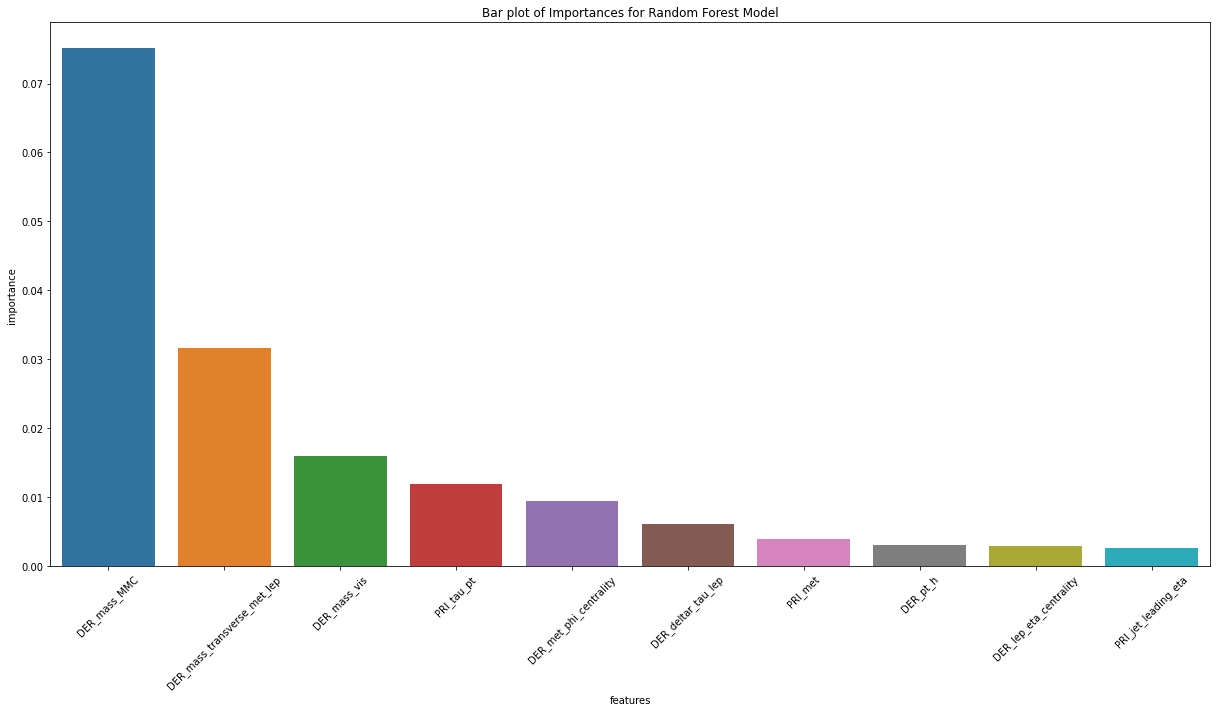

In [ ]:
def permutation_imp(model, imp_features, imp, impstd = 0):
    return pd.DataFrame({'features':imp_features, 'importance':imp, 'importance_std': impstd}
                       ).sort_values('importance', ascending=False)
features_imp =permutation_importance(random_forest, x_val, y_val)
imp_feature_df = permutation_imp(random_forest,list(x_train.columns),features_imp['importances_mean'],features_imp['importances_std']).iloc[:10]
fig,ax=plt.subplots(figsize=(17,10))
sns.barplot(data=imp_feature_df,x='features',y='importance',label='Random forest importance',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Random Forest Model")

**Inference:** 
- This plot shows the 10 important features for the random forest model using the permutation importance

### For upsampled data
- Here, we are using the upsampled data we obtained using SMOTE for the random forest model 
- We are using the gridsearchcv to obtain the best parameters which gives us the best recall for the model

In [ ]:

random_forest_up = RandomForestClassifier(n_estimators = 10,random_state = 44)

# Fit the model on the training set
# tried depth from 1,2, 3, 4, .....14 but got 14 
parameters = [17, 18, 19, 20]
param_grid = { 'criterion':['gini'],'max_depth': parameters, 'min_samples_leaf': [3, 4, 5, 6, 7]}
best = best_classifier(random_forest_up, param_grid,x_train_up, y_train_up, n_folds = 5, scoring = "recall")
print(best)

BEST {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 3} 0.85
RandomForestClassifier(max_depth=19, min_samples_leaf=3, n_estimators=10,
                       random_state=44)


In [ ]:
random_forest_up = RandomForestClassifier(criterion = 'gini', n_estimators = 100, max_depth = 19 , min_samples_leaf = 3,  random_state = 44)

random_forest_up.fit(x_train_up, y_train_up)

y_pred_rf_up = random_forest_up.predict(x_val)
cm_test_rf_up = confusion_matrix(y_val, y_pred_rf_up)

f_score_rf_up = f1_score(y_val, y_pred_rf_up)

recall_rf_up = (cm_test_rf_up[1][1])/cm_test_rf_up.sum(axis=1)[1]

print(f'Accuracy for test set for Random Forest Classifier for up sampled data= {(cm_test_rf_up[0][0] + cm_test_rf_up[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Random Forest Classifier for up sampled data= {recall_rf_up:.4f}')
print(f'F1 score for upsampled data : {f_score_rf_up:.4f} ')

Accuracy for test set for Random Forest Classifier for up sampled data= 0.8307
Accuracy for TPR/recall for Random Forest Classifier for up sampled data= 0.8051
F1 score for upsampled data : 0.7659 


In [ ]:
y_val_i = y_val.values.tolist()
ams_rf_up = evaluation(y_val_i, y_pred_rf_up, weights)
print(f"The AMS value from Random Forest for Up Sampled data: {ams_rf_up}")

The AMS value from Random Forest for Up Sampled data: 1.139979982483361


**Inference:** 
- We can observe that the recall, f1 score and accuracy improved for the model which used upsampled data instead of just using the imbalanced data but the AMS score seems to be decreased slightly compared to the imbalanced data 

Text(0.5, 1.0, 'Bar plot of Importances for Random Forest Model')

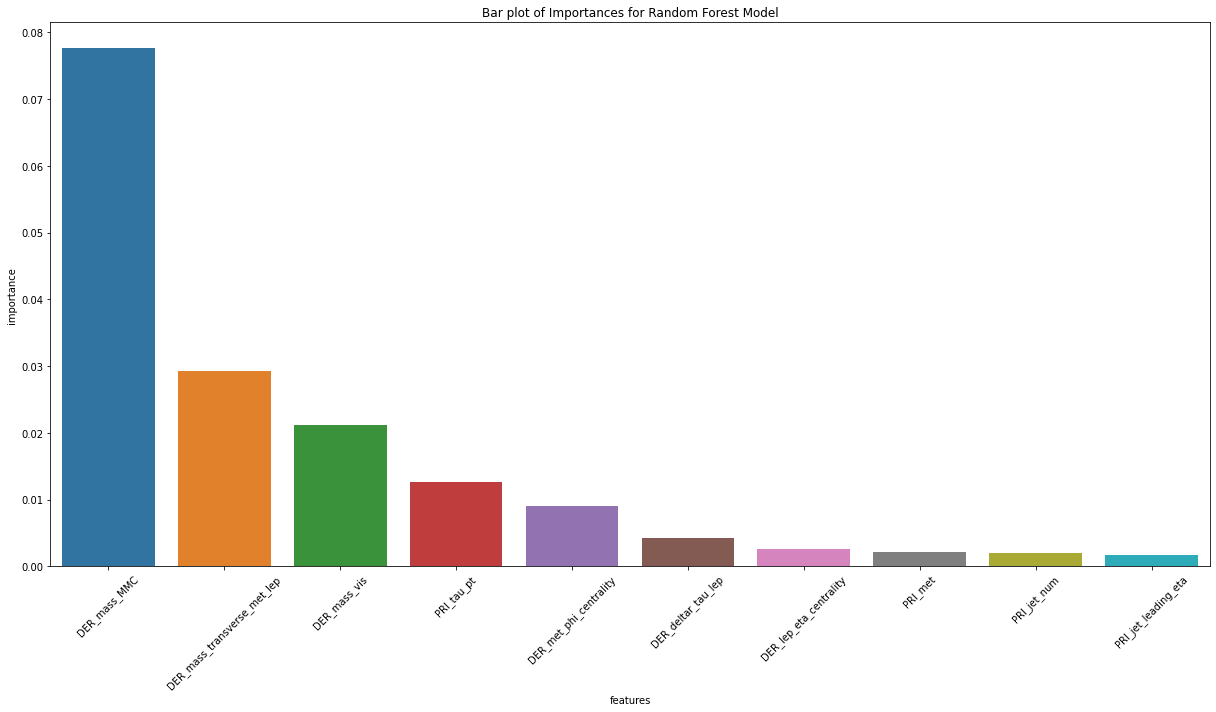

In [ ]:
def permutation_imp(model, imp_features, imp, impstd = 0):
    return pd.DataFrame({'features':imp_features, 'importance':imp, 'importance_std': impstd}
                       ).sort_values('importance', ascending=False)
features_imp =permutation_importance(random_forest_up, x_val, y_val)
imp_feature_df = permutation_imp(random_forest_up,list(x_train.columns),features_imp['importances_mean'],features_imp['importances_std']).iloc[:10]
fig,ax=plt.subplots(figsize=(17,10))
sns.barplot(data=imp_feature_df,x='features',y='importance',label='Random forest importance',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Random Forest Model for Up sampled data")

**Inference:** 
- This plot shows the 10 important features for the random forest model using the permutation importance for the upsampled data

###  For undersampled data
- Here, we are using the undersampled data we obtained using randomundersampler for the random forest model 
- We are using the gridsearchcv to obtain the best parameters which gives us the best recall for the model

In [ ]:
random_forest_down = RandomForestClassifier(n_estimators = 10,random_state = 44)

# Fit the model on the training set
# tried depth from 1,2, 3, 4, .....14 but got 14 
parameters = [4, 6, 8, 10, 12, 14, 17]
param_grid = { 'criterion':['gini'],'max_depth': parameters, 'min_samples_leaf': [3, 4, 5, 6, 7]}
best = best_classifier(random_forest_down, param_grid,x_train_down, y_train_down, n_folds = 5, scoring = "recall")
print(best)

BEST {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 4} 0.82
RandomForestClassifier(max_depth=12, min_samples_leaf=4, n_estimators=10,
                       random_state=44)


In [ ]:
random_forest_down = RandomForestClassifier(criterion = 'gini', n_estimators = 100, max_depth = 12 , min_samples_leaf = 4,  random_state = 44)

random_forest_down.fit(x_train_down, y_train_down)

y_pred_rf_down = random_forest_down.predict(x_val)
cm_test_rf_down = confusion_matrix(y_val, y_pred_rf_down)

f_score_rf_down = f1_score(y_val, y_pred_rf_down)

recall_rf_down = (cm_test_rf_down[1][1])/cm_test_rf_down.sum(axis=1)[1]

print(f'Accuracy for test set for Random Forest Classifier for up sampled data= {(cm_test_rf_down[0][0] + cm_test_rf_down[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Random Forest Classifier for up sampled data= {recall_rf_down:.4f}')
print(f'F1 score for upsampled data : {f_score_rf_down:.4f} ')

Accuracy for test set for Random Forest Classifier for up sampled data= 0.8199
Accuracy for TPR/recall for Random Forest Classifier for up sampled data= 0.8239
F1 score for upsampled data : 0.7589 


In [ ]:
y_val_i = y_val.values.tolist()
ams_rf_down = evaluation(y_val_i, y_pred_rf_down, weights)
print(f"The AMS value from Random Forest for Up Sampled data: {ams_rf_down}")

The AMS value from Random Forest for Up Sampled data: 1.0915859785533266


**Inference:** 
- We can observe that the recall, f1 score and accuracy improved for the model which used downsampled data instead of just using the imbalanced data but the AMS score seems to be decreased slightly compared to the imbalanced data 

Text(0.5, 1.0, 'Bar plot of Importances for Random Forest Model for down sampled data')

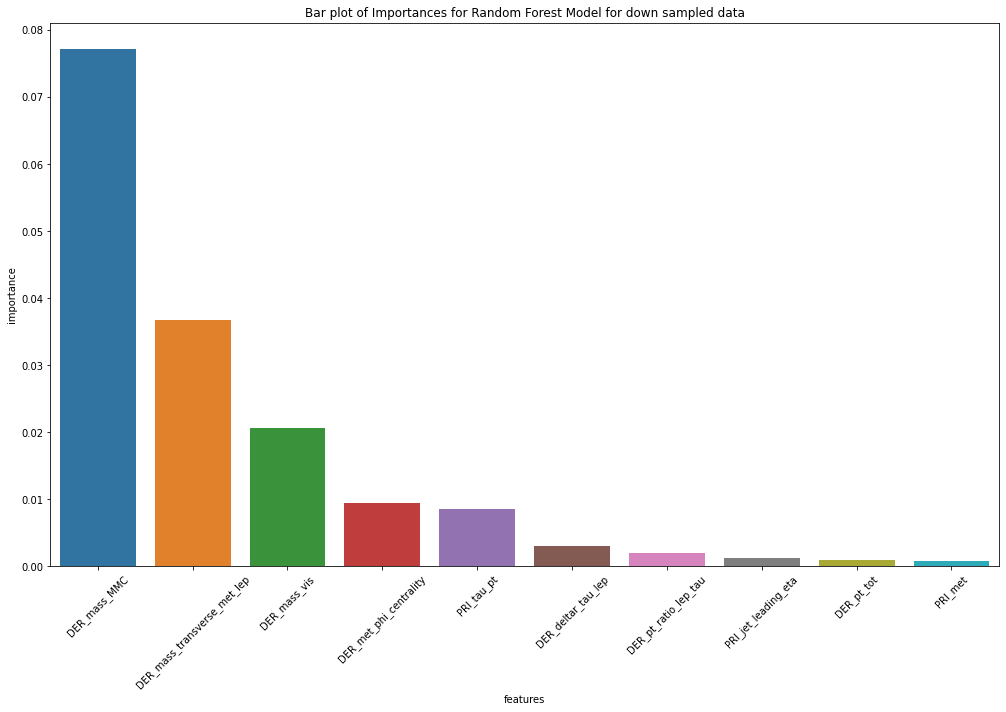

In [ ]:
def permutation_imp(model, imp_features, imp, impstd = 0):
    return pd.DataFrame({'features':imp_features, 'importance':imp, 'importance_std': impstd}
                       ).sort_values('importance', ascending=False)
features_imp =permutation_importance(random_forest_down, x_val, y_val)
imp_feature_df = permutation_imp(random_forest_down,list(x_train.columns),features_imp['importances_mean'],features_imp['importances_std']).iloc[:10]
fig,ax=plt.subplots(figsize=(17,10))
sns.barplot(data=imp_feature_df,x='features',y='importance',label='Random forest importance',ax=ax)
plt.xticks(rotation='45')
plt.title("Bar plot of Importances for Random Forest Model for down sampled data")

**Inference:** 
- This plot shows the 10 important features for the random forest model using the permutation importance for the downsampled data

## AdaBoost

### Imbalanced data
- We are using the adaboost to the imbalance data
- Here, we have used the best value for the parameters of the adaboost that will give the best recall for the model

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 3), 
                            algorithm = 'SAMME', n_estimators=30)

# Fit on the entire data
boost.fit(x_train,y_train)
y_pred_boost = boost.predict(x_val)
cm_test_boost = confusion_matrix(y_val, y_pred_boost)

f_score_boost = f1_score(y_val, y_pred_boost)

recall_boost = (cm_test_boost[1][1])/cm_test_boost.sum(axis=1)[1]

print(f'Accuracy for test set for Random Forest Classifier = {(cm_test_boost[0][0] + cm_test_boost[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Random Forest Classifier= {recall_boost:.4f}')
print(f'F1 score : {f_score_boost} ')

Accuracy for test set for Random Forest Classifier = 0.8250
Accuracy for TPR/recall for Random Forest Classifier= 0.7016
F1 score : 0.7339901477832513 


In [ ]:
y_val_i = y_val.values.tolist()
ams_boost = evaluation(y_val_i, y_pred_boost, weights)
print(f"The AMS value from Ada Boost: {ams_boost}")

The AMS value from Ada Boost: 1.1529176908359158


**Inference:**
- Here, we have calculated the accuracy, recall, F1 score and AMS score for the adaboost
- We can observe that the accuracy, recall, F1 score and AMS score is less for adaboost compared to the random forest model
- So we haven't checked for the balanced data since the AMS score is less for the balanced data

##  Bagging


### Imbalanced data
- We are using the bagging to the imbalance data
- Here, we have used the best value for the parameters of the bagging that will give the best recall for the model

In [ ]:
from sklearn.ensemble import BaggingClassifier
base_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, min_samples_leaf = 3,  random_state = 44)
bag = BaggingClassifier(base_model, n_estimators = 30)
bag.fit(x_train, y_train)

y_pred_bag = bag.predict(x_val)
cm_test_bag = confusion_matrix(y_val, y_pred_bag)

f_score_bag = f1_score(y_val, y_pred_bag)

recall_bag = (cm_test_bag[1][1])/cm_test_bag.sum(axis=1)[1]

print(f'Accuracy for test set for Bagging= {(cm_test_bag[0][0] + cm_test_bag[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Bagging= {recall_bag:.4f}')
print(f'F1 score for Bagging : {f_score_bag:.4f} ')

Accuracy for test set for Bagging= 0.8328
Accuracy for TPR/recall for Bagging= 0.7098
F1 score for Bagging : 0.7449 


In [ ]:
y_val_i = y_val.values.tolist()
ams_bag = evaluation(y_val_i, y_pred_bag, weights)
print(f"The AMS value from Bagging: {ams_bag}")

The AMS value from Bagging: 1.2319294947821933


**Inference:**
- Here, we have calculated the accuracy, recall, F1 score and AMS score for the bagging model
- We can observe that the accuracy, recall, F1 score and AMS score is slightly less for bagging model compared to the random forest model

### Upsampled data
- Here, we are using the upsampled data we obtained using SMOTE for the bagging model

In [ ]:
base_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 9 , min_samples_leaf = 7,  random_state = 44)
bag_up = BaggingClassifier(base_model, n_estimators = 30)
bag_up.fit(x_train_up, y_train_up)

y_pred_bag_up = bag_up.predict(x_val)
cm_test_bag_up = confusion_matrix(y_val, y_pred_bag_up)

f_score_bag_up = f1_score(y_val, y_pred_bag_up)

recall_bag_up = (cm_test_bag_up[1][1])/cm_test_bag_up.sum(axis=1)[1]

print(f'Accuracy for test set for Bagging for up sampled= {(cm_test_bag_up[0][0] + cm_test_bag_up[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Bagging for up sampled= {recall_bag_up:.4f}')
print(f'F1 score for Bagging for upsampled: {f_score_bag_up:.4f} ')

Accuracy for test set for Bagging= 0.8172
Accuracy for TPR/recall for Bagging= 0.8129
F1 score for Bagging : 0.7537 


In [ ]:
y_val_i = y_val.values.tolist()
ams_bag_up = evaluation(y_val_i, y_pred_bag_up, weights)
print(f"The AMS value from Bagging for upsampled: {ams_bag_up}")

The AMS value from Bagging: 1.0683764030861642


**Inference:** 
- We can observe that the recall, f1 score and accuracy improved for the model which used upsampled data instead of just using the imbalanced data but the AMS score seems to be decreased slightly compared to the imbalanced data 

###  For undersampled data
- Here, we are using the undersampled data we obtained using randomundersampler for the bagging model 

In [ ]:
base_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 10 , min_samples_leaf = 5,  random_state = 44)
bag_down= BaggingClassifier(base_model, n_estimators = 30)
bag_down.fit(x_train_down, y_train_down)

y_pred_bag_down = bag_down.predict(x_val)
cm_test_bag_down = confusion_matrix(y_val, y_pred_bag_down)

f_score_bag_down = f1_score(y_val, y_pred_bag_down)

recall_bag_down = (cm_test_bag_down[1][1])/cm_test_bag_down.sum(axis=1)[1]

print(f'Accuracy for test set for Bagging for down sampled data= {(cm_test_bag_down[0][0] + cm_test_bag_down[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Bagging for down sampled data= {recall_bag_down:.4f}')
print(f'F1 score for Bagging for down sampled data: {f_score_bag_down:.4f} ')

Accuracy for test set for Bagging for down sampled data= 0.8175
Accuracy for TPR/recall for Bagging for down sampled data= 0.8214
F1 score for Bagging for down sampled data: 0.7560 


In [ ]:
y_val_i = y_val.values.tolist()
ams_bag_down = evaluation(y_val_i, y_pred_bag_down, weights)
print(f"The AMS value from Bagging: {ams_bag_down}")

The AMS value from Bagging: 1.0732800461346796


**Inference:** 
- We can observe that the recall, f1 score and accuracy improved for the model which used downsampled data instead of just using the imbalanced data but the AMS score seems to be decreased slightly compared to the imbalanced data 

## Gradient Boosting Model


### Imbalanced data
- We are using the gradient boost model to the imbalance data
- Here, we have used the best value for the parameters of the gradient boost that will give the best recall for the model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=150, max_depth=3,random_state=44)
gb.fit(x_train, y_train)


y_pred_gb = gb.predict(x_val)
cm_test_gb = confusion_matrix(y_val, y_pred_gb)

f_score_gb = f1_score(y_val, y_pred_gb)

recall_gb = (cm_test_gb[1][1])/cm_test_gb.sum(axis=1)[1]

print(f'Accuracy for test set for Gradient boosting= {(cm_test_gb[0][0] + cm_test_gb[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Gradient boosting= {recall_gb:.4f}')
print(f'F1 score for Bagging : {f_score_gb:.4f} ')


Accuracy for test set for Gradient boosting= 0.8346
Accuracy for TPR/recall for Gradient boosting= 0.7100
F1 score for Bagging : 0.7471 


In [ ]:
y_val_i = y_val.values.tolist()
ams_gb = evaluation(y_val_i, y_pred_gb, weights)
print(f"The AMS value from Gradient boosting: {ams_gb}")

The AMS value from Gradient boosting: 1.2347303376860324


**Inference:**
- Here, we have calculated the accuracy, recall, F1 score and AMS score for the gradient boost model
- We can observe that the accuracy, recall, F1 score and AMS score is slightly less for gradient boost model compared to the random forest model

### Upsampled data
- Here, we are using the upsampled data we obtained using SMOTE for the bagging model

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier
gb_up = GradientBoostingClassifier(n_estimators=150, max_depth=3,random_state=44)
gb_up.fit(x_train_up, y_train_up)


y_pred_gb_up = gb_up.predict(x_val)
cm_test_gb_up = confusion_matrix(y_val, y_pred_gb_up)

f_score_gb_up = f1_score(y_val, y_pred_gb_up)

recall_gb_up = (cm_test_gb_up[1][1])/cm_test_gb_up.sum(axis=1)[1]

print(f'Accuracy for test set for Gradient boosting for up sampled data= {(cm_test_gb_up[0][0] + cm_test_gb_up[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Gradient boosting for up sampled data= {recall_gb_up:.4f}')
print(f'F1 score for Gradient boosting Up sampled : {f_score_gb_up:.4f} ')

Accuracy for test set for Gradient boosting for up sampled data= 0.8224
Accuracy for TPR/recall for Gradient boosting for up sampled data= 0.8078
F1 score for Gradient boosting Up sampled : 0.7579 


In [ ]:
y_val_i = y_val.values.tolist()
ams_gb_up = evaluation(y_val_i, y_pred_gb_up, weights)
print(f"The AMS value from Gradient boosting for upsampled data: {ams_gb_up}")

The AMS value from Gradient boosting for upsampled data: 1.0885904703442195


**Inference:** 
- We can observe that the recall, f1 score and accuracy improved for the model which used upsampled data instead of just using the imbalanced data but the AMS score seems to be decreased slightly compared to the imbalanced data 

###  For undersampled data
- Here, we are using the undersampled data we obtained using randomundersampler for the bagging model 

In [ ]:
gb_down = GradientBoostingClassifier(n_estimators=150, max_depth=3,random_state=44)
gb_down.fit(x_train_down, y_train_down)


y_pred_gb_down = gb_down.predict(x_val)
cm_test_gb_down = confusion_matrix(y_val, y_pred_gb_down)

f_score_gb_down = f1_score(y_val, y_pred_gb_down)

recall_gb_down = (cm_test_gb_down[1][1])/cm_test_gb_down.sum(axis=1)[1]

print(f'Accuracy for test set for Gradient boosting for down sampled data= {(cm_test_gb_down[0][0] + cm_test_gb_down[1][1])/len(y_val):.4f}')
print(f'Accuracy for TPR/recall for Gradient boosting for down sampled data= {recall_gb_down:.4f}')
print(f'F1 score for Gradient boosting down sampled : {f_score_gb_down:.4f} ')

Accuracy for test set for Gradient boosting for down sampled data= 0.8202
Accuracy for TPR/recall for Gradient boosting for down sampled data= 0.8209
F1 score for Gradient boosting down sampled : 0.7585 


In [ ]:
y_val_i = y_val.values.tolist()
ams_gb_down = evaluation(y_val_i, y_pred_gb_down, weights)
print(f"The AMS value from Gradient boosting for upsampled data: {ams_gb_down}")

The AMS value from Gradient boosting for upsampled data: 1.076775551711466


**Inference:** 
- We can observe that the recall, f1 score and accuracy improved for the model which used downsampled data instead of just using the imbalanced data but the AMS score seems to be decreased slightly compared to the imbalanced data 

# Printing the results of different models

In [ ]:
bag_auc = roc_auc_score(y_val,y_pred_bag)
bag_up_auc = roc_auc_score(y_val,y_pred_bag_up)
bag_down_auc = roc_auc_score(y_val,y_pred_bag_down)

gb_auc = roc_auc_score(y_val,y_pred_gb)
gb_up_auc = roc_auc_score(y_val,y_pred_gb_up)
gb_down_auc = roc_auc_score(y_val,y_pred_gb_down)

In [ ]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ["Strategy","Recall", "F1 Score","AUC score", "AMS"]
pt.add_row(["Bagging - No imbalance correction",round(recall_bag,4), round(f_score_bag,4),round(bag_auc,4), round(ams_bag,4)])
pt.add_row(["Bagging Tree - Upsampling",round(recall_bag_up,4), round(f_score_bag_up,4),round(bag_up_auc,4), round(ams_bag_up,4)])
pt.add_row(["Bagging Tree - Downsampling",round(recall_bag_down,4), round(f_score_bag_down,4),round(bag_down_auc,4),round(ams_bag_down,4)])
print(pt)

+-----------------------------------+--------+----------+-----------+--------+
|              Strategy             | Recall | F1 Score | AUC score |  AMS   |
+-----------------------------------+--------+----------+-----------+--------+
| Bagging - No imbalance correction | 0.7098 |  0.7449  |   0.8035  | 1.2319 |
|     Bagging Tree - Upsampling     | 0.8155 |  0.7534  |   0.8161  | 1.0661 |
|    Bagging Tree - Downsampling    | 0.8214 |  0.756   |   0.8185  | 1.0733 |
+-----------------------------------+--------+----------+-----------+--------+


In [ ]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ["Strategy","Recall", "F1 Score","AUC score", "AMS"]
pt.add_row(["Gradient Boosting - No imbalance correction",round(recall_gb,4), round(f_score_gb,4),round(gb_auc,4), round(ams_gb,4)])
pt.add_row(["Gradient Boosting - Upsampling",round(recall_gb_up,4), round(f_score_gb_up,4),round(gb_up_auc,4), round(ams_gb_up,4)])
pt.add_row(["Gradient Boosting - Downsampling",round(recall_gb_down,4), round(f_score_gb_down,4),round(gb_down_auc,4),round(ams_gb_down,4)])
print(pt)

+---------------------------------------------+--------+----------+-----------+--------+
|                   Strategy                  | Recall | F1 Score | AUC score |  AMS   |
+---------------------------------------------+--------+----------+-----------+--------+
| Gradient Boosting - No imbalance correction |  0.71  |  0.7471  |   0.805   | 1.2347 |
|        Gradient Boosting - Upsampling       | 0.8078 |  0.7579  |   0.819   | 1.0886 |
|       Gradient Boosting - Downsampling      | 0.8209 |  0.7585  |   0.8204  | 1.0768 |
+---------------------------------------------+--------+----------+-----------+--------+


In [ ]:
print(classification_report(y_val, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82     32798
           1       0.67      0.53      0.59     17202

    accuracy                           0.75     50000
   macro avg       0.73      0.70      0.71     50000
weighted avg       0.74      0.75      0.74     50000



In [ ]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ["Strategy","Recall", "F1 Score","AUC score", "AMS"]
pt.add_row(["Logistic Regression - No imbalance correction",round(recall_logreg,4), round(f_score_logreg,4),round(logreg_auc,4), round(ams_logreg,4)])
pt.add_row(["Logistic Regression - Upsampling",round(recall_logreg_up,4), round(f_score_logreg_up,4),round(logreg_up_auc,4), round(ams_logreg_up,4)])
pt.add_row(["Logistic Regression - Downsampling",round(recall_logreg_down,4), round(f_score_logreg_down,4),round(logreg_down_auc,4),round(ams_logreg_down,4)])
print(pt)


+-----------------------------------------------+--------+----------+-----------+--------+
|                    Strategy                   | Recall | F1 Score | AUC score |  AMS   |
+-----------------------------------------------+--------+----------+-----------+--------+
| Logistic Regression - No imbalance correction | 0.5333 |  0.5946  |   0.6983  | 0.8745 |
|        Logistic Regression - Upsampling       | 0.7624 |  0.6668  |   0.7437  | 0.8852 |
|       Logistic Regression - Downsampling      | 0.7702 |  0.6685  |   0.745   | 0.8901 |
+-----------------------------------------------+--------+----------+-----------+--------+


In [ ]:
print(classification_report(y_val, y_pred_logreg_up))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78     32798
           1       0.59      0.76      0.67     17202

    accuracy                           0.74     50000
   macro avg       0.72      0.74      0.73     50000
weighted avg       0.76      0.74      0.74     50000



In [ ]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ["Strategy","Recall", "F1 Score","AUC score", "AMS"]
pt.add_row(["Decision Tree - No imbalance correction",round(recall_dt,4), round(f_score_dt,4),round(dt_auc,4), round(ams_dt,4)])
pt.add_row(["Decision Tree - Upsampling",round(recall_dt_up,4), round(f_score_dt_up,4),round(dt_up_auc,4), round(ams_dt_up,4)])
pt.add_row(["Decision Tree - Downsampling",round(recall_dt_down,4), round(f_score_dt_down,4),round(dt_down_auc,4),round(ams_dt_down,4)])
print(pt)

+-----------------------------------------+--------+----------+-----------+--------+
|                 Strategy                | Recall | F1 Score | AUC score |  AMS   |
+-----------------------------------------+--------+----------+-----------+--------+
| Decision Tree - No imbalance correction | 0.7045 |  0.732   |   0.7944  | 1.1556 |
|        Decision Tree - Upsampling       | 0.8025 |  0.7418  |   0.8066  | 1.0252 |
|       Decision Tree - Downsampling      | 0.8154 |  0.7417  |   0.8072  | 1.0072 |
+-----------------------------------------+--------+----------+-----------+--------+


In [ ]:
pt = PrettyTable()
pt.field_names = ["Strategy","Recall", "F1 Score","AUC score", "AMS"]
pt.add_row(["Random Forest - No imbalance correction",round(recall_rf,4), round(f_score_rf,4),round(rf_auc,4), round(ams_rf,4)])
pt.add_row(["Random Forest - Upsampling",round(recall_rf_up,4), round(f_score_rf_up,4),round(rf_up_auc,4), round(ams_rf_up,4)])
pt.add_row(["Random Forest - Downsampling",round(recall_rf_down,4), round(f_score_rf_down,4),round(rf_down_auc,4),round(ams_rf_down,4)])
print(pt)

+-----------------------------------------+--------+----------+-----------+--------+
|                 Strategy                | Recall | F1 Score | AUC score |  AMS   |
+-----------------------------------------+--------+----------+-----------+--------+
| Random Forest - No imbalance correction | 0.7089 |  0.7504  |   0.8071  | 1.2851 |
|        Random Forest - Upsampling       | 0.8051 |  0.7659  |   0.8246  |  1.14  |
|       Random Forest - Downsampling      | 0.8239 |  0.7589  |   0.8209  | 1.0916 |
+-----------------------------------------+--------+----------+-----------+--------+


# Plotting ROC Curve

In [ ]:
logreg_auc = roc_auc_score(y_val,y_pred_logreg)
logreg_up_auc = roc_auc_score(y_val,y_pred_logreg_up)
logreg_down_auc = roc_auc_score(y_val,y_pred_logreg_down)

dt_auc = roc_auc_score(y_val,y_pred_dt)
dt_up_auc = roc_auc_score(y_val,y_pred_dt_up)
dt_down_auc = roc_auc_score(y_val,y_pred_dt_down)

rf_auc = roc_auc_score(y_val,y_pred_rf)
rf_up_auc = roc_auc_score(y_val,y_pred_rf_up)
rf_down_auc = roc_auc_score(y_val,y_pred_rf_down)


In [ ]:
def plot_roc(test,logprobs,logprobs_up, logprobs_down, dtprobs, dtprobs_up, dtprobs_down, rfprobs, rfprobs_up, rfprobs_down,axis):
    log_fpr, log_tpr, log_thresholds = roc_curve(test, logprobs)
    log_up_fpr, log_up_tpr, log_up_thresholds = roc_curve(test, logprobs_up)
    log_down_fpr, log_down_tpr, log_down_thresholds = roc_curve(test, logprobs_down)

    dt_fpr, dt_tpr, dt_thresholds = roc_curve(test, dtprobs)
    dt_up_fpr, dt_up_tpr, dt_up_thresholds = roc_curve(test, dtprobs_up)
    dt_down_fpr, dt_down_tpr, dt_down_thresholds = roc_curve(test, dtprobs_down)
    
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(test, rfprobs)
    rf_up_fpr, rf_up_tpr, rf_up_thresholds = roc_curve(test, rfprobs_up)
    rf_down_fpr, rf_down_tpr, rf_down_thresholds = roc_curve(test, rfprobs_down)
    
    ax.plot(log_fpr, log_tpr, label=f'Logistic Regression (area = {logreg_auc:.2f})')
    ax.plot(log_up_fpr, log_up_tpr, label=f'Logistic Regression Upsampled (area = {logreg_up_auc:.2f})')
    ax.plot(log_down_fpr, log_down_tpr, label=f'Logistic Regression Undersampled(area = {logreg_down_auc:.2f})')
    
    ax.plot(dt_fpr, dt_tpr, label=f'Decision Tree (area = {dt_auc:.2f})')
    ax.plot(dt_up_fpr, dt_up_tpr, label=f'Decision Tree  Upsampled (area = {dt_up_auc:.2f})')
    ax.plot(dt_down_fpr, dt_down_tpr, label=f'Decision Tree Undersampled(area = {dt_down_auc:.2f})')

    ax.plot(rf_fpr, rf_tpr, label=f'Random Forest (area = {rf_auc:.2f})')
    ax.plot(rf_up_fpr, rf_up_tpr, label=f'Random Forest Upsampled (area = {rf_up_auc:.2f})')
    ax.plot(rf_down_fpr, rf_down_tpr, label=f'Random Forest Undersampled(area = {rf_down_auc:.2f})')

    #ax.plot(kfpr, ktpr, label=f'KNN (area = {knnreg_auc:.2f})', color = 'g')  
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.4,
    )
   
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve for Improving Recall')
    ax.legend(loc="lower right",fontsize=8)

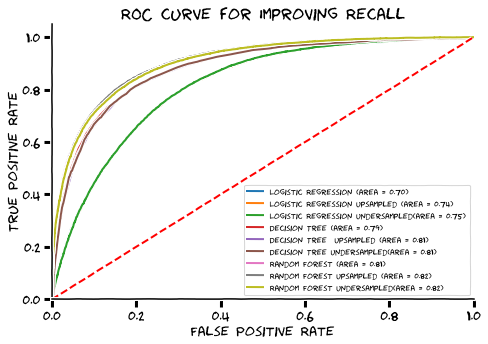

In [ ]:
plt.xkcd(randomness=0,scale=0.1)
y_probs_log = logreg.predict_proba(x_val)[:,1]
y_probs_log_up = logreg_up.predict_proba(x_val)[:,1]
y_probs_log_down = logreg_down.predict_proba(x_val)[:,1]
y_probs_dt = dt.predict_proba(x_val)[:,1]
y_probs_dt_up = dt_up.predict_proba(x_val)[:,1]
y_probs_dt_down = dt_down.predict_proba(x_val)[:,1]
y_probs_rf = random_forest.predict_proba(x_val)[:,1]
y_probs_rf_up = random_forest_up.predict_proba(x_val)[:,1]
y_probs_rf_down = random_forest_down.predict_proba(x_val)[:,1]

#y_kprobs = knnreg.predict_proba(X_test)[:,1]
fig, ax = plt.subplots(figsize = (7,5))
fig.patch.set_facecolor('None')
fig.patch.set_alpha(0)
plot_roc(y_val,y_probs_log,y_probs_log_up,y_probs_log_down,y_probs_dt,y_probs_dt_up,y_probs_dt_down,y_probs_rf,y_probs_rf_up,y_probs_rf_down,ax)
[ax.spines[key].set_visible(False) for key in ax.spines.keys() if key not in ['bottom','left']];
ax.patch.set_facecolor('None')
ax.patch.set_alpha(0)
plt.tight_layout()

**Inference:**
- Random forest does a slightly better job than every other models

# Inference and conclusion
- Up/Down sampling gave better accuracy, recall, f1 but AMS went down for decision tree based models. For Logistic regression it slightly improved AMS.
- Tuning hyperparameters using F1 score did not provide any significant benefit.
- Random Forest model tuned using F1 score gives slightly more AMS compared to other ensemble models
- **Feature Importance:** Derived columns seems to be more important compare to Primary columns.


# Improvements
- Feature Engineering: Log transform.
- Better estimation for AMS. (Bootstrap)
- Better way to incorporate invalid values.
